# Proteorhodopsin Transcipts per cell
## about the dataset
+ MunsonMcgee2022 took water samples in the open ocean, assembled all genomes found and linked them to individual cells in that sample
+ several parameters were measured and/or estimated:
    + biovolume: forward scattering
    + respiration rate: RSG luminescense, calibrated against winkler bulk respiration rates
    + min. doubling times: codon usage bias (gRodon)
+ from this dataset, several subsets were used depending on the scope of each part of the analysis
## sidenotes
+ when trying to answer the question, whether PR usage has a significant/systematic effect on cell metabolism, one could try to use respiration rate as a proxy
+ in order to eliminate as much sources of error, the respiration rate will therefore be "normalized" with given cell properties

In [33]:
#%matplotlib inline

In [34]:
# library issue hotfixes
#import piplite
#await piplite.install('plotly')
#await piplite.install('nbformat')

## PR transcript binning
### Material & Methods
+ imported dataset from Mcgee git: Fig3F_rhodopsin_per_µm.csv
  + grouped by species (?), 2-3 measurements/samples for each
  + notable columns:
    + PR transcript count per cell
    + weighted average O2 consumption of several genera against PR transcripts per cell
    + PR transcripts per biovolume
+ dataset was grouped according to the number of PR transcripts of each species
+ histogram plot and table were created in order to get an impession about the distribution of all values
+ notes:
  + further information about the dataset, among others about compilation/origin of the data is missing, probably this data is an excerpt of the full dataset found in the supplementary information S3 and S4

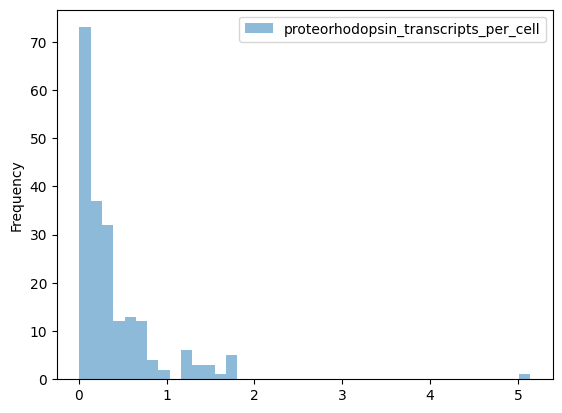

In [35]:
import numpy as np
#from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import math


fields_f3f = ['genus', 'proteorhodopsin_transcripts_per_cell']
genus, PRtranscripts = fields_f3f
df_prdist = (pd
    .read_csv("csv_inputs/Fig3F_rhodopsin_per_µm.csv", usecols=fields_f3f)
    )

ax = df_prdist.plot.hist(column=PRtranscripts, bins=40, alpha=0.5)
plt.show()
#df_prdist['avg'] = df_prdist.groupby([genus])[PRtranscripts].transform('mean')
#print(df_prdist.drop_duplicates('genus'))
#df_prdist.drop_duplicates('genus').to_csv('df_prdist.csv')


In [36]:
histogram = (pd
             .DataFrame()
             .assign(bins_pr=pd.cut(df_prdist[PRtranscripts], bins=40))
             .assign(counts=lambda x: x.groupby('bins_pr')['bins_pr'].transform('count'))
             .drop_duplicates('bins_pr')
             .sort_values(by='bins_pr')
             .assign(percentage=lambda x: x['counts']/df_prdist[PRtranscripts].size)
             .reset_index(drop=True)   
        )
print(histogram)

print("Bins with PR transcript count <1:" , histogram[histogram['bins_pr'].apply(lambda  x: x.right < 1)]['percentage'].sum())
print("Bins with PR transcript count <2:" , histogram[(histogram['bins_pr'].apply(lambda  x: x.left > 1)) & (histogram['bins_pr'].apply(lambda  x: x.right < 2))]['percentage'].sum())


             bins_pr  counts  percentage
0   (0.00305, 0.136]      73    0.357843
1     (0.136, 0.265]      37    0.181373
2     (0.265, 0.393]      32    0.156863
3     (0.393, 0.521]      12    0.058824
4      (0.521, 0.65]      13    0.063725
5      (0.65, 0.778]      12    0.058824
6     (0.778, 0.906]       4    0.019608
7     (0.906, 1.035]       2    0.009804
8     (1.163, 1.291]       6    0.029412
9     (1.291, 1.419]       3    0.014706
10    (1.419, 1.548]       3    0.014706
11    (1.548, 1.676]       1    0.004902
12    (1.676, 1.804]       5    0.024510
13     (5.012, 5.14]       1    0.004902
Bins with PR transcript count <1: 0.8970588235294118
Bins with PR transcript count <2: 0.08823529411764705


### Observations
Around 89,7% of all bacteria genera contained a transcript count between 0 and 1. A second group could possibly be made out in the range of 1 to 2 Proteorhodopsin transcripts per cell, which account for around 8,8% of the total percentage of all bacteria in the dataset with 204. The number of proteorhodopsin transcripts probably doesn't follow a normal distribution. One Outlier could be identified in the range of 5.012 and 5.14 PR transcripts per cell.



## Boxplots grouped by transcript bins
### Material & Methods
+ 2 groups were defined based on observations from Fig3F PR transcript distribution: [0, 1] and ]1, 8[
+ merged S3S4 dataframe with data from Fig3F
    + inner merge **-> each value of 
+ created boxplot grouped by these groups, comparing different properties between them
    + aim: get an idea which properties, if any, could be influenced by PR usage (-> transcript cound)

In [37]:
df_S3S4 = (pd
           .read_csv("csv_outputs/df_S3S4.csv"))
print(df_S3S4.to_string())
df_S3S4prdist = (pd
                .merge(df_S3S4, df_prdist, on='genus', how='inner')
)
print(df_S3S4prdist)
#df_S3S4prdist.to_csv('df_S3S4prdist.csv')

      Unnamed: 0.1        name  estimated_diameter (µm)  Sample_collection_Date (yymmdd)  Predicted_respiration_rate_fmol_O2_per_hr  GTDB_classification                                                                                                                          GTDBtk_full_classification  biovolume  resp_nm_bvol               family2           GTDB_genus              genus  #_of_cells Proteorhodopsin encoded  resp_med  resp_log  resp_nm_bvol_med  resp_nm_bvol_log  Unnamed: 0     Assemblyname          d        Name  grates_log  resp_nm_bvol_gr  resp_nm_bvol_gr_med  resp_nm_bvol_gr_log  resp_nm_gr  resp_nm_gr_med  resp_nm_gr_log
0                0  AH-135-A03                     0.31                           170412                                   0.004335             IMCC9063                                       d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Pelagibacterales;f__Pelagibacteraceae;g__IMCC9063;s__   0.015599      0.277882     Pelagibacteraceae      

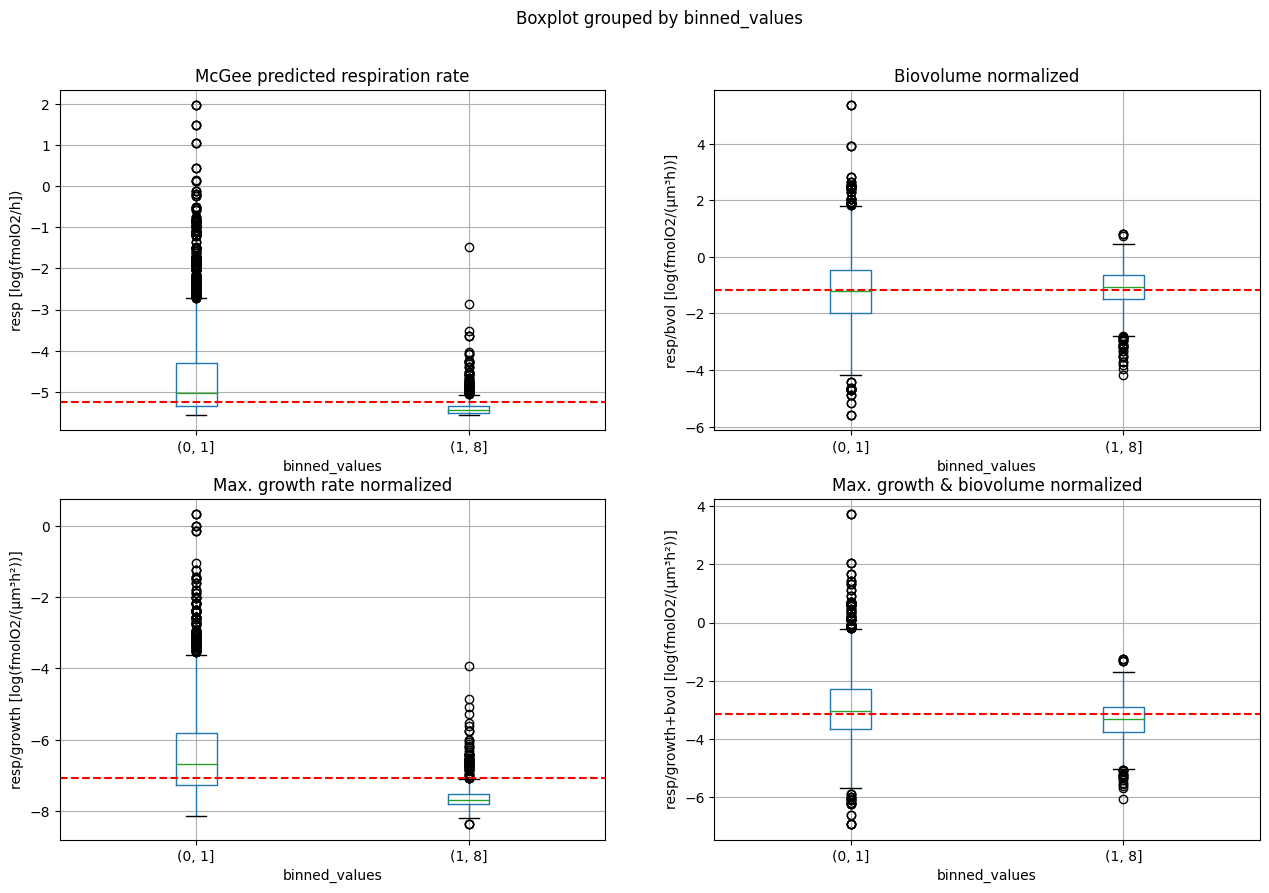

In [38]:
prenc = 'Proteorhodopsin encoded'
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 8)])
df_S3S4prdist['binned_values'] = pd.cut(df_S3S4prdist['proteorhodopsin_transcripts_per_cell'], bins)
def qualiplots():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    df_S3S4prdist.boxplot(column=['resp_log'], by='binned_values', ax=axes[0,0])
    df_S3S4prdist.boxplot(column=['resp_nm_bvol_log'], by='binned_values', ax=axes[0,1])
    df_S3S4prdist.boxplot(column=['resp_nm_gr_log'], by='binned_values', ax=axes[1,0])
    df_S3S4prdist.boxplot(column=['resp_nm_bvol_gr_log'], by='binned_values', ax=axes[1,1])

    ### Labelling etc.
    axes[0,0].axhline(y = math.log(df_S3S4['resp_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[0,1].axhline(y = math.log(df_S3S4['resp_nm_bvol_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[1,0].axhline(y = math.log(df_S3S4['resp_nm_gr_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[1,1].axhline(y = math.log(df_S3S4['resp_nm_bvol_gr_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[0,0].set_title('McGee predicted respiration rate')
    axes[0,1].set_title('Biovolume normalized')
    axes[1,0].set_title('Max. growth rate normalized')
    axes[1,1].set_title('Max. growth & biovolume normalized')
    axes[0,0].set_ylabel('resp [log(fmolO2/h])')
    axes[0,1].set_ylabel('resp/bvol [log(fmolO2/(µm³h))]')
    axes[1,0].set_ylabel('resp/growth [log(fmolO2/(µm³h²))]')
    axes[1,1].set_ylabel('resp/growth+bvol [log(fmolO2/(µm³h²))]')
    plt.show()
qualiplots();

As can be seen in previous figure, respiration rate is significantly higher for bacteria in the group with PR transcripts below 1. The same is true if normalized with max growth rate. Biovolume normalized respiration rate however produces the opposite result. When normalized with both max. growth rate and biovolume, the effect of max. growth rate seems to outweigh the latter. All 4 plots follow the same pattern as in previous figure (respiration_pr_use.ipynb) but the trend seems to be much more obvious.

In [39]:
# Anzeige in separatem Fenster:
#%matplotlib qt

In the following figure, a scatter plot with bacteria respiration rate over the number PR transcripts was created. All bacteria were grouped by family, as it is easier to differentiate biological features/relationships and connect the knowledge about hte PR usage of different families with these datapoints.

In [48]:
import plotly.express as px
from sklearn.cluster import KMeans
import math
import plotly.graph_objects as go

# dataframe preparation
df_S3S4prdist["grates"] = df_S3S4prdist["grates_log"].transform(lambda x: math.exp(x))
df_S3S4prdist_cl = df_S3S4prdist[['family2', 'genus', 'resp_log', 'proteorhodopsin_transcripts_per_cell', 'biovolume', "grates"]]
grouped_df_sorted=(df_S3S4prdist_cl
                    .groupby('genus')
                    .agg(
                        med_resp_log=('resp_log', 'median'), 
                        med_prtr_cell=('proteorhodopsin_transcripts_per_cell', 'mean'), 
                        med_bvol=('biovolume', 'median'), 
                        groupsize=('genus', 'size'),
                        grates=('grates', 'median'),
                        family2=('family2', 'first')
                        )
                    .assign(
                        relsize=lambda x: x['groupsize']/x['groupsize'].sum(),
                        logrelsize=lambda x: x['relsize'].apply(math.log).transform(lambda x: x.max()/x)
                    )
                    .sort_values(by='groupsize', ascending=False)
                    .reset_index()
                )
# kmeans clustering
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, n_init=2, max_iter=3000).fit(grouped_df_sorted[['med_prtr_cell', 'med_resp_log']])
centroids = kmeans.cluster_centers_
#df_S3S4prdist_cl.to_csv("csv_outputs/df_S3S4prdist_cl.csv")
# make scatter plot from data
figure = go.Figure()
figure.add_trace(
                go.Scatter(
                    name='groups (biovolume)',
                    y=grouped_df_sorted['med_resp_log'], x=grouped_df_sorted['med_prtr_cell'], 
                    mode='markers',
                    marker=go.scatter.Marker(
                        sizemode='area', 
                        size=grouped_df_sorted['med_bvol'],
                        sizeref=(max(grouped_df_sorted.med_bvol)/(80.**2)),
                        sizemin=2,
                        opacity=grouped_df_sorted.logrelsize,   # <------------- opacity = relative size between 0 and 1
                        color=kmeans.labels_
                        )
                    )
                )
figure.add_trace(
                go.Scatter(
                    name='groups (gr. rates)',
                    y=grouped_df_sorted['med_resp_log'], x=grouped_df_sorted['med_prtr_cell'], 
                    mode='markers',
                    marker=go.scatter.Marker(
                        sizemode='area', 
                        size=grouped_df_sorted['grates'],
                        sizeref=(max(grouped_df_sorted.grates)/(20.**2)),
                        sizemin=2,
                        opacity=grouped_df_sorted.logrelsize,   # <------------- opacity = relative size between 0 and 1
                        color=kmeans.labels_,
                        reversescale=True
                        ),
                    visible=False
                    )
                )
# draw centroids                
figure.add_trace(
                go.Scatter(
                    name='centroids',
                    x=centroids[:,0], y=centroids[:,1], 
                    marker=dict(color='rgba(188, 189, 34,0.2)', size=20, line=dict(color='blue', width=2), opacity=0.8), 
                    mode='markers'
                    )
                )
figure.update_traces(
                customdata = np.stack( (grouped_df_sorted['genus'], grouped_df_sorted['family2'], grouped_df_sorted['groupsize'], grouped_df_sorted['med_bvol'], grouped_df_sorted['grates'], kmeans.labels_), axis=-1),
                hovertemplate = "<b>Genus: %{customdata[0]}</b><br>" \
                    "Family: %{customdata[1]}<br>" \
                    "group size: %{customdata[2]}<br>" \
                    "Biovolume (median): %{customdata[3]:.4f} <br>" \
                    "PR count (median): %{x:.4f} <br>" \
                    "log respiration rate (median): %{y:.4f}<br>" \
                    "log max. growth rate (median): %{customdata[3]:.4f}<br>" \
                    #"group: %{customdata[5]}",
                )
figure.update_traces(
                )
figure.update_traces(
                selector=({'name':'centroids'}),
                hovertemplate = "PR count (median): %{x:.4f} <br>log respiration rate (median): %{y:.4f}" 
                )

figure.update_layout(
                    plot_bgcolor='white', 
                    width=1200, height=800,
                    margin=dict(r=20,t=20,b=10),
                    legend=dict(
                        title="kMeans Clusters",
                        itemclick="toggleothers",
                        itemsizing="constant",
                        traceorder="normal",
                        xanchor="right",
                        yanchor="top",
                        y=1.15
                        )
                    )
figure.update_yaxes(title_text='Respiration rate (log) [log(fmolO2/h]', 
                    linecolor='black',  
                    linewidth=2.4, 
                    mirror=True,
                    ticks='outside',
                    tickwidth=2.4,
                    range=[-5.65, -2.85]
                 )
figure.update_xaxes(title_text='Proteorhodopsin transcript (median) count',
                    linecolor='black',
                    linewidth=2.4,
                    mirror=True,
                    ticks='outside',
                    tickwidth=2.4,
                    range=[-0.15, 1.70]
                 )
figure.update_layout(
    autosize=False,
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    visible=True,
                    args=[{'visible':[True, False, True]}],
                    args2=[{'visible':['legendonly', False, False]}],
                    label="Biovolume",
                    method="restyle"
                ),
                dict(
                    visible=True,
                    args=[{'visible': [False, True, True]}],
                    args2=[{'visible':[False, 'legendonly', False]}],
                    label="Growth rate",
                    method="restyle"
                ),
            ]),
            xanchor="left",
            yanchor="top",
            direction="down",
            showactive=True,
            y=1.1
        )
    ]
)
figure.show()

#TODO: add kmeans.labels_ as column to dataframe in order to be able to sort them in the future / use this in scatter plots

In [41]:
# print(centroids)
#
# df_centroids = (grouped_df_sorted
#
#                 .assign(
#
#                     cgroup=kmeans.labels_
#
#                 ))
#
# print(df_centroids.sort_values(by=['cgroup', 'groupsize'], ascending=False).to_string())
#df_centroids.to_csv('csv_outputs/df_cgroups.csv')

[[ 0.2621505  -5.14570398]
 [ 0.14591722 -3.57509071]
 [ 1.04430439 -5.35071467]]
              genus  med_resp_log  med_prtr_cell  med_bvol  groupsize    grates              family2   relsize  logrelsize  cgroup
0      Pelagibacter     -5.460587       1.588507  0.011494       1260  9.733661    Pelagibacteraceae  0.267006    1.000000       2
10       AAA536-G10     -5.382786       0.904779  0.077952        111  7.702547           AAA536-G10  0.023522    0.352146       2
17           HIMB59     -4.979677       1.393896  0.022449         63  7.291897               HIMB59  0.013350    0.305936       2
25          UBA4441     -5.254151       0.953223  0.052809         30  3.542712      Emcibacteraceae  0.006357    0.261061       2
26       Litoricola     -5.379040       0.730230  0.096967         30  3.456964       Litoricolaceae  0.006357    0.261061       2
32          UBA4588     -5.309699       0.994824  0.080704         18  2.992406  Puniceispirillaceae  0.003814    0.237114       2
4

+ as suspected, there are no cells with high PR count and high respiration rate. This could be a confirmation/indication that PR utilization is mainly relevant under oligotrophic conditions/for oligotrophic bacteria.
3 groups assumed:
+ 0 = average type / "mixotrophic" (?) -> low metabolism, little usage of PR depending on circumstances
+ 1 =                "oligotrophic"    -> low metabolism, PR plays significant role in aiding metabolism
+ 2 =  ??
+ group 1 consists mainly of "Rhodobacteraceae", which are Alphaproteobacteria with known usage of Bacteriochlorophyll-a
    + 2 groups maybe more sensible? 
**TODO:**
    + determine size (samplecount) of groups
    + subplot with 2 groups

Spearman Coefficient:

In [42]:
print(grouped_df_sorted[['med_prtr_cell', 'med_resp_log']].corr(method='spearman'))

               med_prtr_cell  med_resp_log
med_prtr_cell       1.000000     -0.474958
med_resp_log       -0.474958      1.000000


In [43]:

figure = px.scatter(
                    grouped_df_sorted, 
                    y='med_resp_log', x='med_prtr_cell', 
                    size='med_bvol', color='genus',
                    hover_name='genus',
                    hover_data={'med_bvol':':.4f', 'genus':False, 'groupsize':True, 'med_bvol':True, 'family2':True},
                    )

figure.update_traces(
                    marker=dict(
                        sizemode='area', 
                        sizeref=(max(grouped_df_sorted.med_bvol)/(80.**2)),
                        sizemin=2
                        )
                    )
figure.update_layout(
                # matplotlib like formatting
                    plot_bgcolor='white', 
                    width=1200, height=800,
                    margin=dict(r=20,t=20,b=10),
                # legend layout
                    legend=dict(
                        title="Genera",
                        itemclick="toggleothers",
                        itemsizing="constant",
                        traceorder="normal"
                        )
                    )
figure.update_yaxes(title_text='Respiration rate (log) [log(fmolO2/h]', 
                    linecolor='black',  
                    linewidth=2.4, 
                    mirror=True,
                    ticks='outside',
                    tickwidth=2.4,
                    range=[-5.65, -2.85]
                 )
figure.update_xaxes(title_text='Proteorhodopsin transcript (median) count',
                    linecolor='black',
                    linewidth=2.4,
                    mirror=True,
                    ticks='outside',
                    tickwidth=2.4,
                    range=[-0.15, 1.70]
                 )
figure.show()

### grouping: PR encoding vs. transcript count


## Methods
+ outer join of S4 genus statistics, which contains PR encoding (bool) and F3f, which contains the PR transcript number
+ aim: gain information about origin/compilation of dataframe F3f, detect mismatches/lost data when merging S4 and F3f

In [44]:

S4cols = ['GTDB_genus', '#_of_cells', 'Proteorhodopsin encoded']
genusS4, cellnrS4, prencS4 = S4cols
df_S4 = (pd
    .read_csv("csv_inputs/S4_genus.csv", usecols=S4cols)
    .query("GTDB_genus != 'Unclassified'")
    )
print("Zellzahl von Datenframe S4 ohne Unclassified: " , int(df_S4[cellnrS4].sum()))
df_S4F3f = (pd
            .merge(df_S4, df_prdist, left_on=genusS4, right_on='genus', how='right')
            )
prcutoff = df_S4F3f[df_S4F3f[PRtranscripts] == df_S4F3f[PRtranscripts].min()]
print("Minimum PR transcript count for PR encoded == yes: " , prcutoff[PRtranscripts].to_list()[0])

Zellzahl von Datenframe S4 ohne Unclassified:  4105
Minimum PR transcript count for PR encoded == yes:  0.0081859891780986


+ results of outer join S4 with prdist: 
    + prdist probably a subset of S4
    + genera, where all values in Fig3E / Fig3F for PR transcripts per cell were 0 for all samples -> dropped
    + notable: SW10, akkermansicae were dropped
    + all cells, where  "PR encoded == No" were missing in hte Fig3F dataset
    + still error with mismatch of data possible, 20 biggest genera: no mismatch
-> left/inner join preferred
    + minimum PR transcript count for PR encoded == yes: ~0.008

## Violin plots with kmeans bins


1577


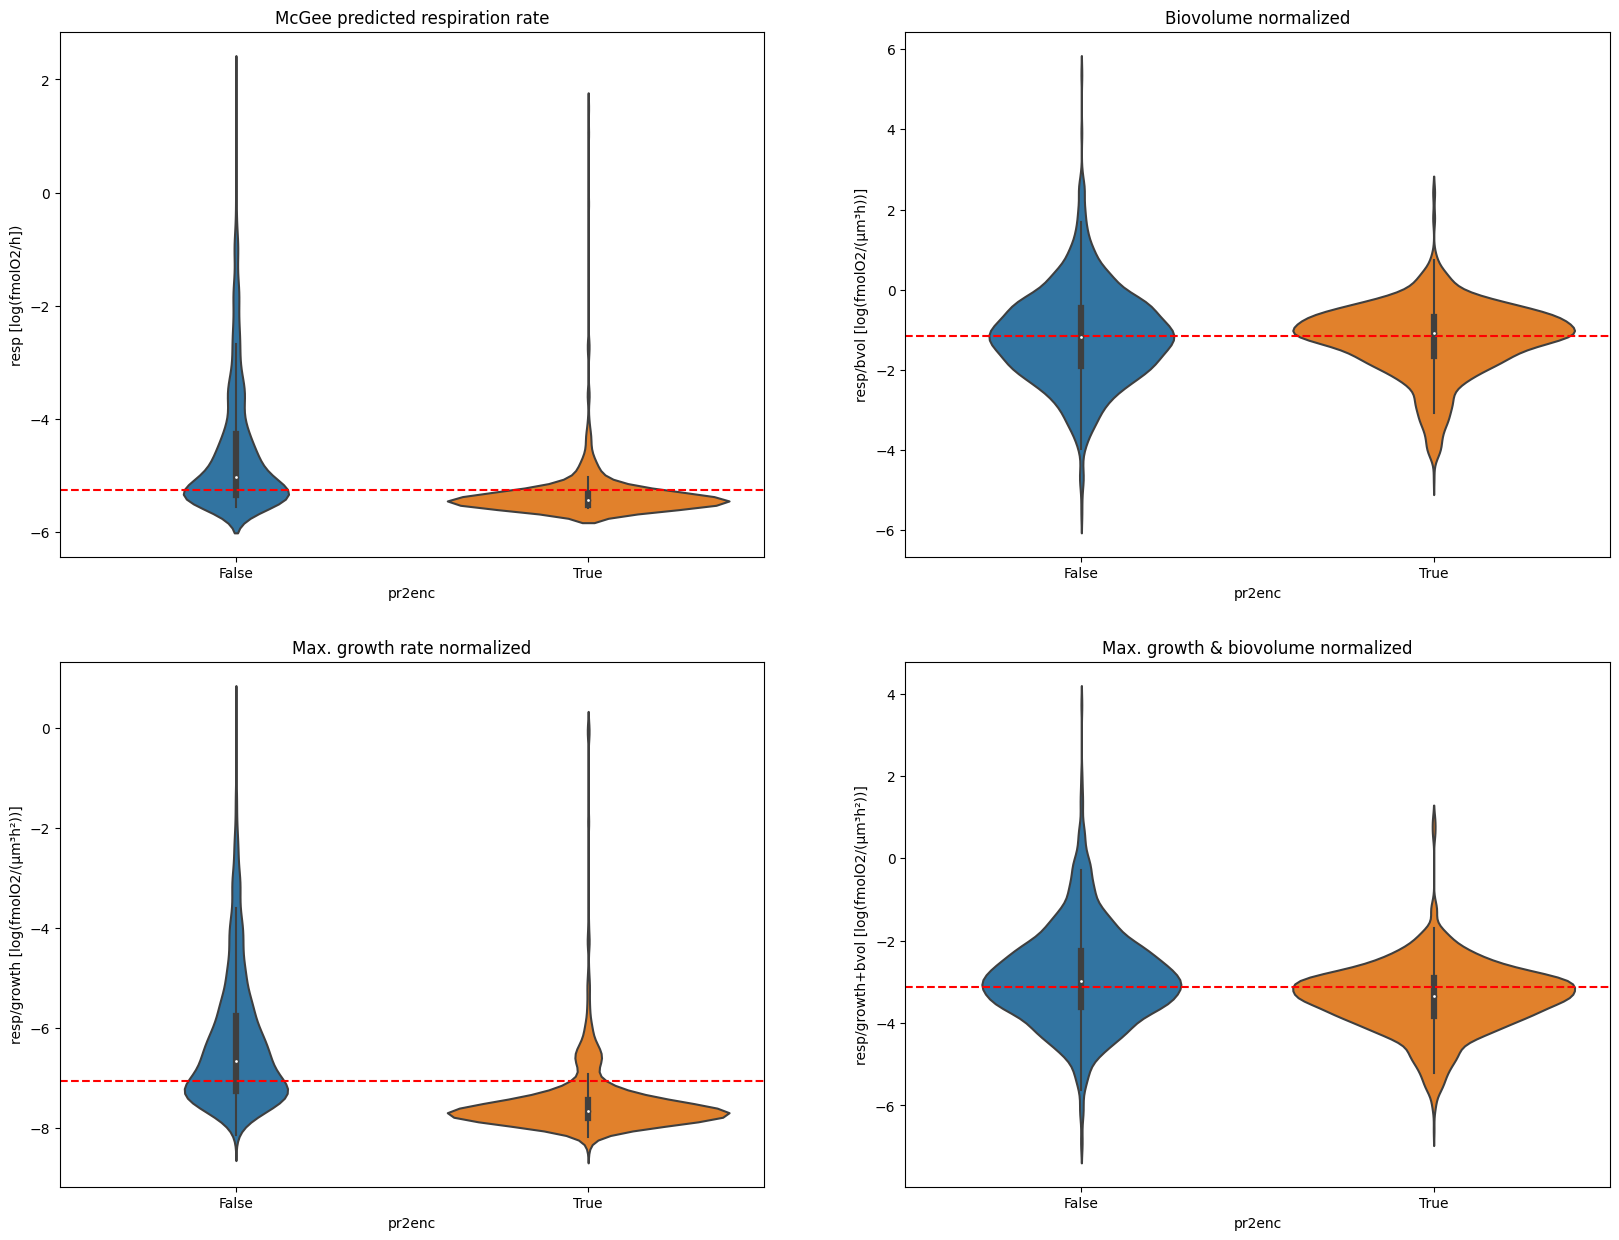

In [45]:
import seaborn as sns

prenc = 'Proteorhodopsin encoded'
#bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 8)])
df_S3S4prdist['binned_values'] = pd.cut(df_S3S4prdist['proteorhodopsin_transcripts_per_cell'], bins)
groups = {True: 'Yes', False: 'No'}
prenc_cutoff=(sum(centroids[:,0])/len(centroids[:,0]))
#print(df_S3S4prdist.to_string())
df_S3S4prdist['pr2enc'] = (df_S3S4prdist['proteorhodopsin_transcripts_per_cell'] > prenc_cutoff)
print(df_S3S4prdist[df_S3S4prdist['pr2enc'] == True].shape[0])
def violinplots():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
    sns.violinplot(y='resp_log', x='pr2enc', data=df_S3S4prdist, ax=axes[0,0])
    sns.violinplot(y='resp_nm_bvol_log', x='pr2enc', data=df_S3S4prdist, ax=axes[0,1])
    sns.violinplot(y='resp_nm_gr_log', x='pr2enc', data=df_S3S4prdist, ax=axes[1,0])
    sns.violinplot(y='resp_nm_bvol_gr_log', x='pr2enc', data=df_S3S4prdist, ax=axes[1,1])

    ### Labelling etc.
    axes[0,0].axhline(y = math.log(df_S3S4['resp_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[0,1].axhline(y = math.log(df_S3S4['resp_nm_bvol_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[1,0].axhline(y = math.log(df_S3S4['resp_nm_gr_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[1,1].axhline(y = math.log(df_S3S4['resp_nm_bvol_gr_med'].iloc[0]), color = 'r', linestyle = '--')
    axes[0,0].set_title('McGee predicted respiration rate')
    axes[0,1].set_title('Biovolume normalized')
    axes[1,0].set_title('Max. growth rate normalized')
    axes[1,1].set_title('Max. growth & biovolume normalized')
    axes[0,0].set_ylabel('resp [log(fmolO2/h])')
    axes[0,1].set_ylabel('resp/bvol [log(fmolO2/(µm³h))]')
    axes[1,0].set_ylabel('resp/growth [log(fmolO2/(µm³h²))]')
    axes[1,1].set_ylabel('resp/growth+bvol [log(fmolO2/(µm³h²))]')
    plt.show()
violinplots();

+ max growth rate nromalized: both peaks below median
+ more or less same picture as before

In [46]:
# export important variables for usage in other files

# cutoff boundaries (kmeans bins, pr transcript counts)
print(prenc_cutoff)
#print(df_S3S4.to_string())

0.48412404091369377
